## Dimensionality reduction: synthetic data

### Step 1: read synthetic data and get data matrix

In [1]:
import sys
import numpy as np
import cantera as ct
import matplotlib.pylab as plt

# input file
fname1 = 'x_b5.txt'
fname2 = 'y_b5.txt'

fid1 = open(fname1,'r')
fid2 = open(fname2,'r')

x = np.fromfile(fid1, sep=' ')
y = np.fromfile(fid2, sep=' ')

nx = x.size    # size of data
nv = 2         # number of variables

# data matrix
X = np.zeros((nx,nv))
X[:,0] = x
X[:,1] = y

#### Plot data

Text(0.5, 0, 'Time (ms)')

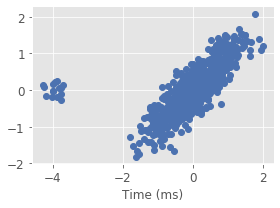

In [2]:
# plot reaction rates
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (4,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
plt.figure()
plt.plot(x,y, 'o')
plt.xlabel('Time (ms)')
# plt.ylabel('Reaction rate');

### Step 2: Compute principal values and vectors

#### Scaling data matrix

In [3]:
def scaleData(nf, v):

    # compute mean
    v_mean = np.mean(v, axis=0)
#     print(v_mean)
    v_max = np.max(np.abs(v), axis=0)
#     print(v_max)

    # add for loop to scale the data: NORMALIZATION
    for i in range(nf):
        v[:, i] = (v[:, i] - v_mean[i])/v_max[i]
#         v[:, i] = (v[:, i])/v_max[i]

    return None

Xs = np.zeros((nx,nv)) # scaled data matrix
Xs = np.copy(X)

scaleData(nv,Xs)
print(Xs)

[[ 0.04579083 -0.11694883]
 [ 0.10642451  0.18288682]
 [-0.00360463 -0.20817833]
 ...
 [-0.91550439  0.07314406]
 [-0.96979324  0.03714631]
 [-0.1043739  -0.49983294]]


#### Co-variance matrix

In [4]:
def covar(u):
    mom = np.zeros((nv, nv), dtype=float, order='F')
    # compute covariance matrix
    for j in range(nv):
        for i in range(nv):
            for n in range(nx):
                mom[i,j] = mom[i,j] + u[n,i] * u[n,j]                
    mom = mom/nx    
#     mom=np.true_divide(mom, nx)
#     print(mom)
    return mom

mom2 = np.zeros((nv, nv), dtype=float, order='F')
mom2 = covar(Xs)
print(mom2)

[[0.04474126 0.04428097]
 [0.04428097 0.10827869]]


#### Co-kurtosis tensor (matricized)

In [5]:
def cokurt(u):
    tmp = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
    # compute cokurtosis matrix
    for l in range(nv):
        for k in range(nv):
            for j in range(nv):
                for i in range(nv):
                    for n in range(nx):
                        tmp[i,j,k,l] = tmp[i,j,k,l] + u[n,i] * u[n,j] * u[n,k] * u[n,l]
    
    tmp=tmp/nx
    return tmp


mom4_t = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
mom4_t = cokurt(Xs)

In [6]:
mom4 = np.reshape(mom4_t,(nv,nv*nv*nv),order='F')
print(mom4)

[[0.01790006 0.00308432 0.00308432 0.00610166 0.00308432 0.00610166
  0.00610166 0.01280285]
 [0.00308432 0.00610166 0.00610166 0.01280285 0.00610166 0.01280285
  0.01280285 0.03123114]]


#### Cumulant Excess-kurtosis tensor (matricized)

In [7]:
def excesskurt(u):
    tmp = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
    # compute cokurtosis matrix
    for l in range(nv):
        for k in range(nv):
            for j in range(nv):
                for i in range(nv):
                    for n in range(nx):
                        tmp[i,j,k,l] = tmp[i,j,k,l] + u[n,i] * u[n,j] * u[n,k] * u[n,l]    
    
    tmp=tmp/nx
    
    for l in range(nv):
        for k in range(nv):
            for j in range(nv):
                for i in range(nv):
                    tmp[i,j,k,l] = tmp[i,j,k,l] - mom2[i,j]*mom2[k,l] - mom2[i,k]*mom2[j,l] - mom2[i,l]*mom2[j,k]
                    
    return tmp


mom42_t = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
mom42_t = excesskurt(Xs)

In [8]:
mom42 = np.reshape(mom42_t,(nv,nv*nv*nv),order='F')
print(mom42)

[[ 0.01189471 -0.00285924 -0.00285924 -0.00266447 -0.00285924 -0.00266447
  -0.00266447 -0.00158121]
 [-0.00285924 -0.00266447 -0.00266447 -0.00158121 -0.00266447 -0.00158121
  -0.00158121 -0.00394168]]


#### Principal values and vectors

In [9]:
# factorize co-variance matrix: SVD of the covariance matrix
U2, S2, V2 = np.linalg.svd(mom2)

# factorize co-kurtosis tensor
U4, S4, V4 = np.linalg.svd(mom4)

# factorize excess-kurtosis tensor
U42, S42, V42 = np.linalg.svd(mom42)

In [10]:
# print(U2)
print(U2)
print(U4)
print(U42)

[[-0.45665563 -0.88964354]
 [-0.88964354  0.45665563]]
[[-0.47819117 -0.87825578]
 [-0.87825578  0.47819117]]
[[-0.99843397 -0.05594284]
 [-0.05594284  0.99843397]]


#### Plot vectors

(-1.0724367004148498,
 0.5556232942814178,
 -0.9840474178892891,
 1.092837849158082)

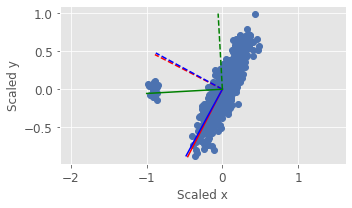

In [11]:
# plot reaction rates
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (5,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
plt.figure()
plt.plot(Xs[:,0],Xs[:,1], 'o')
# second moment vectors
plt.plot([0,U2[0,0]],[0,U2[0,1]],'-r')
plt.plot([0,U2[1,0]],[0,U2[1,1]],'--r')
# fourth moment vectors
plt.plot([0,U4[0,0]],[0,U4[0,1]],'-b')
plt.plot([0,U4[1,0]],[0,U4[1,1]],'--b')
# fourth moment vectors
plt.plot([0,U42[0,0]],[0,U42[0,1]],'-g')
plt.plot([0,U42[1,0]],[0,U42[1,1]],'--g')
plt.xlabel('Scaled x')
plt.ylabel('Scaled y')
plt.axis('equal')

### Step 3: Data reduction

In [12]:
# function to get truncated matrix
def truncateVecs(nv,q,U):
    U_q = np.zeros((nv,q), dtype=float, order='F')
    U_q = np.copy(U[:,0:q,])
    return U_q

In [13]:
# function to construct PC data
def constructPCData(nx,q,Xs,Uq):
    Z_q = np.zeros((nx,q), dtype=float, order='F')
    Z_q = np.matmul(Xs,Uq)
    return Z_q

In [14]:
# function to reconstruct original data
def reconstructData(nv,nx,Zq,Uq):
    X_sq = np.zeros((nx,nv), dtype=float, order='F')
    X_sq = np.matmul(Zq,Uq.transpose())
    return X_sq

In [15]:
q = 1
U2q = np.zeros((nv,q), dtype=float, order='F')
Z2q = np.zeros((nx,q), dtype=float, order='F')
Xs2q = np.zeros((nx,nv), dtype=float, order='F')

U2q = truncateVecs(nv,q,U2)
Z2q = constructPCData(nx,q,Xs,U2q)
Xs2q = reconstructData(nv,nx,Z2q,U2q)

Es2 = Xs-Xs2q
print(Es2)

[[ 0.08375359 -0.04299087]
 [ 0.00993161 -0.00509791]
 [ 0.08172174 -0.04194792]
 ...
 [-0.75430582  0.38718654]
 [-0.78264911  0.4017352 ]
 [ 0.12045414 -0.06182933]]


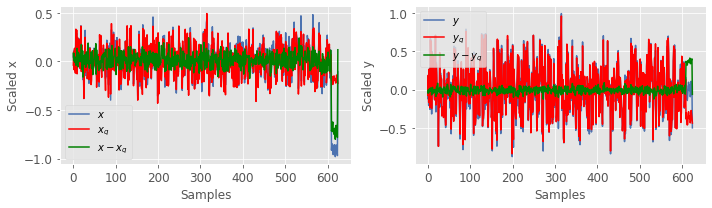

In [21]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (10,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(Xs[:,0], '-')
ax1.plot(Xs2q[:,0], '-r')
ax1.plot(Es2[:,0], '-g')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Scaled x')
ax1.legend(['$x$', '$x_q$', '$x-x_q$'])
ax2.plot(Xs[:,1], '-')
ax2.plot(Xs2q[:,1], '-r')
ax2.plot(Es2[:,1], '-g')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Scaled y')
ax2.legend(['$y$', '$y_q$', '$y-y_q$'])

In [17]:
q = 1
U4q = np.zeros((nv,q), dtype=float, order='F')
Z4q = np.zeros((nx,q), dtype=float, order='F')
Xs4q = np.zeros((nx,nv), dtype=float, order='F')

U4q = truncateVecs(nv,q,U4)
Z4q = constructPCData(nx,q,Xs,U4q)
Xs4q = reconstructData(nv,nx,Z4q,U4q)

Es4 = Xs-Xs4q
print(Es4)

[[ 0.08443548 -0.04597328]
 [ 0.00528102 -0.0028754 ]
 [ 0.08464915 -0.04608962]
 ...
 [-0.73687756  0.4012138 ]
 [-0.76363422  0.41578223]
 [ 0.12940986 -0.07046086]]


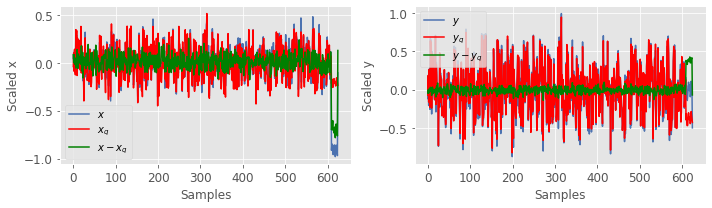

In [22]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (10,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(Xs[:,0], '-')
ax1.plot(Xs4q[:,0], '-r')
ax1.plot(Es4[:,0], '-g')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Scaled x')
ax1.legend(['$x$', '$x_q$', '$x-x_q$'])
ax2.plot(Xs[:,1], '-')
ax2.plot(Xs4q[:,1], '-r')
ax2.plot(Es4[:,1], '-g')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Scaled y')
ax2.legend(['$y$', '$y_q$', '$y-y_q$'])

In [19]:
q = 1
U42q = np.zeros((nv,q), dtype=float, order='F')
Z42q = np.zeros((nx,q), dtype=float, order='F')
X42q = np.zeros((nx,nv), dtype=float, order='F')

U42q = truncateVecs(nv,q,U42)
Z42q = constructPCData(nx,q,Xs,U42q)
Xs42q = reconstructData(nv,nx,Z42q,U42q)

Es42 = Xs-Xs42q
print(Es42)

[[ 0.00667551 -0.11914049]
 [-0.00988212  0.17637009]
 [ 0.01161657 -0.20732547]
 ...
 [-0.00695064  0.12405086]
 [-0.00510988  0.09119808]
 [ 0.02759163 -0.49243884]]


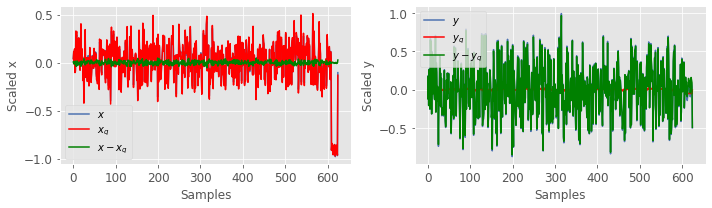

In [23]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (10,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(Xs[:,0], '-')
ax1.plot(Xs42q[:,0], '-r')
ax1.plot(Es42[:,0], '-g')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Scaled x')
ax1.legend(['$x$', '$x_q$', '$x-x_q$'])
ax2.plot(Xs[:,1], '-')
ax2.plot(Xs42q[:,1], '-r')
ax2.plot(Es42[:,1], '-g')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Scaled y')
ax2.legend(['$y$', '$y_q$', '$y-y_q$'])